# Linear Regression and Neural Network models
## Step by step plan:

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

*Train test split*<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Independent variable normalization<br>

### Model creation and evaluation
- Parameter evaluation<br>
- Actual vs predicted target variable analysis<br>
- Residuals analysis<br>

### Created models:
- One linear model<br>
- One linear model using exclusively significant independent variables<br>
- One neural network model<br>
- One linear model using PCA (some exploratory analysis is done for PCA results)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import ceil, floor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, normaltest, kstest, pearsonr
from scipy.special import inv_boxcox

In [2]:
sns.set() # makes all charts look better by default

## Data Ingestion

In [3]:
aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
# Last accessed at 2024-03-23

In [4]:
aijobs # first look at the data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Machine Learning Scientist,196350,USD,196350,US,100,US,M
1,2024,SE,FT,Machine Learning Scientist,127500,USD,127500,US,100,US,M
2,2024,MI,FT,Data Scientist,116259,USD,116259,AU,0,AU,M
3,2024,MI,FT,Data Scientist,88995,USD,88995,AU,0,AU,M
4,2024,EN,FT,Data Science,46080,USD,46080,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
14709,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
14710,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
14711,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
14712,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


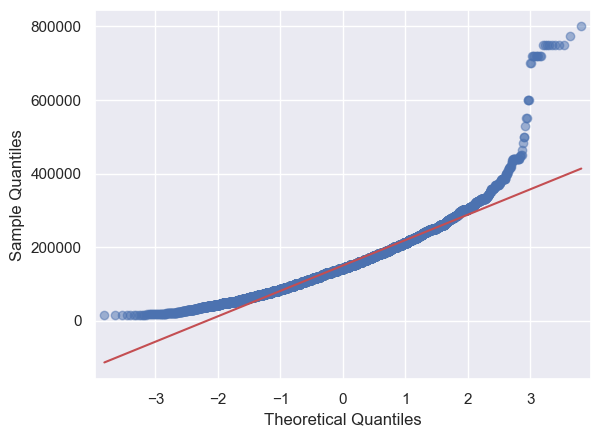

In [5]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling
These steps would be equally done for train and test bases with no population or sampled information, only individual ones, so no data leakage will occur if done now.

### Outlier removal

In [6]:
# The first outliers are extremely out of touch with the remainder of the database.
# They will skew the results too much and must be removed.
# According to Hair, from 2.5 to 4 standards deviations might be used to remove outliers.
# Visually, 4 deviations cover the worst cases.

mean = aijobs['salary_in_usd'].mean()
std = mean = aijobs['salary_in_usd'].std()
outmax = mean + 4 * std
print(outmax)
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

345502.2452106102
Index([   66,    70,   233,   323,   341,   368,   370,   482,   506,   530,
       ...
       13008, 13351, 13366, 13545, 14439, 14444, 14496, 14641, 14706, 14709],
      dtype='int64', length=140)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1831,2024,SE,FT,Machine Learning Engineer,345400,USD,345400,US,0,US,M
914,2024,SE,FT,Analytics Engineer,345400,USD,345400,US,0,US,M
2360,2024,SE,FT,Machine Learning Engineer,345400,USD,345400,US,0,US,M
9825,2023,SE,FT,Research Scientist,345000,USD,345000,US,0,US,M
499,2024,SE,FT,Research Scientist,345000,USD,345000,US,0,US,M


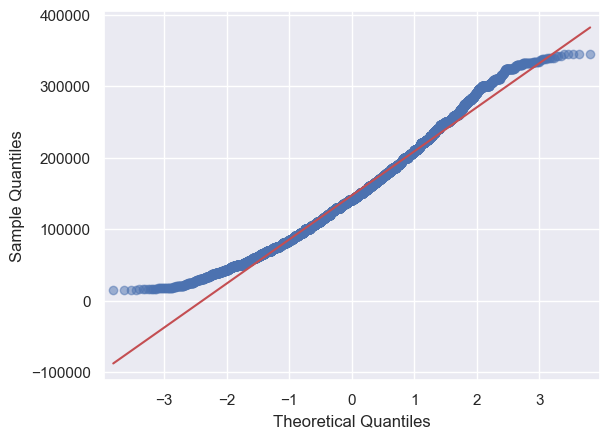

In [7]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

## Feature Engineering

In [8]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [9]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,work_abroad
14564,2020,MI,FT,Data Engineer,USD,130800,ES,100,US,M,1
14565,2020,SE,FT,Machine Learning Engineer,EUR,45618,HR,100,HR,S,0
14566,2021,SE,FT,Director of Data Science,USD,168000,JP,0,JP,S,0
14567,2021,MI,FT,Data Scientist,SGD,119059,SG,100,IL,M,1
14568,2021,MI,FT,Data Engineer,EUR,28369,MT,50,MT,L,0
14569,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,0
14570,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,0
14571,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,0
14572,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,0
14573,2021,SE,FT,Data Science Manager,INR,94665,IN,50,IN,L,0


In [10]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0         Remote
1         Remote
2        On_Site
3        On_Site
4        On_Site
          ...   
14569     Remote
14570     Remote
14571     Remote
14572     Remote
14573     Hybrid
Name: remote_ratio, Length: 14574, dtype: object

In [11]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

In [12]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs['job_title'].unique()), "different job titles \n")
print(aijobs['job_title'].unique())

149 different job titles 

['Machine Learning Scientist' 'Data Scientist' 'Data Science'
 'Business Intelligence Analyst' 'Data Architect' 'Data Engineer'
 'Business Intelligence Engineer' 'Analytics Engineer' 'Data Analyst'
 'Data Science Consultant' 'Data Manager' 'Machine Learning Engineer'
 'Applied Scientist' 'BI Analyst' 'Data Integration Engineer'
 'ML Engineer' 'Research Engineer' 'Data Integration Specialist'
 'Machine Learning Operations Engineer'
 'Machine Learning Infrastructure Engineer' 'Research Scientist'
 'Data Developer' 'Business Intelligence' 'AI Engineer' 'CRM Data Analyst'
 'ETL Developer' 'Business Intelligence Manager' 'Data Science Engineer'
 'Data Analytics Manager' 'Data Specialist' 'AI Architect'
 'Robotics Engineer' 'Research Analyst' 'BI Developer' 'Head of Data'
 'Data Science Manager' 'Data Modeler' 'Cloud Database Engineer'
 'Data Operations Analyst' 'Data Science Analyst'
 'Data Science Practitioner' 'Data Management Analyst' 'BI Data Analyst'
 'Applie

In [13]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs['job_title'].unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

78 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'CRM', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Engineer', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [14]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Consultant', 'Computational', 'Computer', 'Managing', 'Power', 'Sales', 'Tech', 
              'Technician', 'Vehicle', 'Autonomous', 'Compliance', 'DevOps', 'Marketing']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.
# All other ones present themselves only at most in a couple of entries and therefore are prone to overfitting.

In [15]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller','Modeler',
                 'Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager']

In [16]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',       # Typo
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager'}
# Note: Analyst and Analytics in this context will mean different things.

In [17]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning\n", len(synonyms), "synonyms\n ", len(clean_terms)+len(synonyms), "total terms\n")
print(clean_terms)

39 terms after cleaning
 12 synonyms
  51 total terms

['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'CRM', 'Database', 'Decision', 'Deep', 'Developer', 'Director', 'ETL', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Software', 'Specialist', 'Staff', 'Vision', 'Visualization']


In [18]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,job_name_Intelligence,job_name_Business,job_name_Cloud,job_name_Modeler,job_name_Engineer,job_name_Finance,job_name_Research,job_name_Scientist,job_name_Strategist,job_name_Manager
0,2024,SE,FT,Machine Learning Scientist,USD,196350,US,Remote,US,M,...,0,0,0,0,0,0,0,1,0,0
1,2024,SE,FT,Machine Learning Scientist,USD,127500,US,Remote,US,M,...,0,0,0,0,0,0,0,1,0,0
2,2024,MI,FT,Data Scientist,USD,116259,AU,On_Site,AU,M,...,0,0,0,0,0,0,0,1,0,0
3,2024,MI,FT,Data Scientist,USD,88995,AU,On_Site,AU,M,...,0,0,0,0,0,0,0,1,0,0
4,2024,EN,FT,Data Science,USD,46080,US,On_Site,US,M,...,0,0,0,0,0,0,0,1,0,0


In [19]:
# dummization for all other categorical columns
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,SE,FT,Machine Learning Scientist,USD,196350,US,Remote,US,M,...,0,0,0,0,1,0,0,0,1,0
1,2024,SE,FT,Machine Learning Scientist,USD,127500,US,Remote,US,M,...,0,0,0,0,1,0,0,0,1,0
2,2024,MI,FT,Data Scientist,USD,116259,AU,On_Site,AU,M,...,0,0,0,0,0,0,0,0,1,0
3,2024,MI,FT,Data Scientist,USD,88995,AU,On_Site,AU,M,...,0,0,0,0,0,0,0,0,1,0
4,2024,EN,FT,Data Science,USD,46080,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0


In [20]:
aijobs[categorical_columns].describe().loc['unique']

experience_level       4
employment_type        4
salary_currency       22
employee_residence    87
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [21]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')

In [22]:
# Comprehensive dummies will need one instance removed.
# They could be picked by hand, but the algorithm below selects the most popular for deletion.

c_dummies = aijobs[['experience_level_EN', 'experience_level_MI', 'experience_level_SE', 'experience_level_EX']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['employment_type_FL', 'employment_type_PT', 'employment_type_CT', 'employment_type_FT']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['remote_ratio_Remote', 'remote_ratio_Hybrid', 'remote_ratio_On_Site']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['company_size_S', 'company_size_M', 'company_size_L']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

# These larger dummies will be implied in the intercept.
X_vars.remove('salary_currency_USD')
X_vars.remove('employee_residence_US')
X_vars.remove('company_location_US')

X_vars

['work_year',
 'work_abroad',
 'job_name_AI',
 'job_name_Admin',
 'job_name_Analyst',
 'job_name_Analytics',
 'job_name_Applied',
 'job_name_Architect',
 'job_name_Associate',
 'job_name_Big',
 'job_name_Biologist',
 'job_name_CRM',
 'job_name_Database',
 'job_name_Decision',
 'job_name_Deep',
 'job_name_Developer',
 'job_name_Director',
 'job_name_ETL',
 'job_name_Head',
 'job_name_Infrastructure',
 'job_name_Insight',
 'job_name_Integration',
 'job_name_Lead',
 'job_name_NLP',
 'job_name_Ops',
 'job_name_Owner',
 'job_name_Pipeline',
 'job_name_Practitioner',
 'job_name_Principal',
 'job_name_Product',
 'job_name_Programmer',
 'job_name_Prompt',
 'job_name_Quality',
 'job_name_Quantitative',
 'job_name_Reporting',
 'job_name_Robotics',
 'job_name_Software',
 'job_name_Specialist',
 'job_name_Staff',
 'job_name_Vision',
 'job_name_Visualization',
 'job_name_Machine',
 'job_name_Operations',
 'job_name_Intelligence',
 'job_name_Business',
 'job_name_Cloud',
 'job_name_Modeler',
 'job_n

# Splitting and working the data before model fit

In [23]:
X_train, X_test, y_train, y_test = train_test_split(aijobs[X_vars], aijobs['salary_in_usd'], test_size=0.25, random_state=42)

In [24]:
X_train

,work_year,work_abroad,job_name_AI,job_name_Admin,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,...,company_location_SE,company_location_SG,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_VN,company_location_ZA,company_size_L,company_size_S
13633,2022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1835,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4375,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9562,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1805,2024,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13418,2022,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 entries is a minimum threshold; any dummy with less than 5 examples is too prone to overfitting.

def del_vars(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    test_deletion = X_test[exclusion_list].sum(axis=1) # filter a dataframe by select all exclusion rows and their sum
    test_dropped = test_deletion[test_deletion > 0].index # finding all rows with a positive value on any of those dummies
    X_test.drop(test_dropped, inplace=True) # dropping unworkable test rows
    X_test.drop(exclusion_list, axis=1, inplace=True) # dropping columns from test base
    
    # shaping dependent variable arrays to match independent variables dataframes
    y_train.drop(train_dropped, inplace=True)
    y_test.drop(test_dropped, inplace=True)
    if printing == True:
        print("After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [26]:
del_vars(printing=True)

Before: (10930, 246) (10930,) (3644, 246) (3644,)
Rows deleted: 133
Columns dropped: 118
Rows deleted: 28
Columns dropped: 130
Rows deleted: 2
Columns dropped: 132
Rows deleted: 0
Columns dropped: 132
After: (10767, 114) (10767,) (3597, 114) (3597,)


## Box-Cox transformation

Best Lambda Value: 0.5359


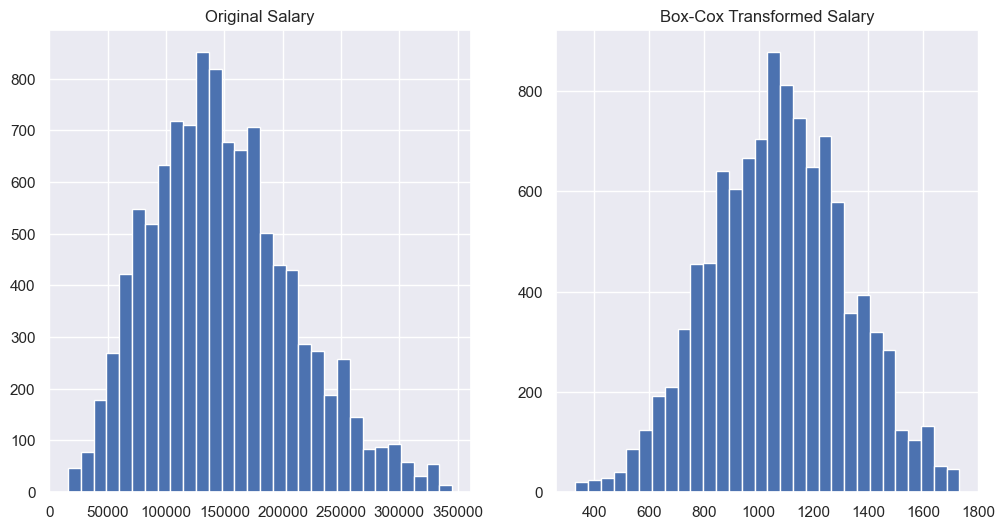

Normal test: NormaltestResult(statistic=33.39314489513961, pvalue=5.6075185550818445e-08)
Kolmogorov-Smirnov test: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=330.1700432414338, statistic_sign=-1)


In [27]:
# fit the lambda and transform the train dependent variable
y_train_original = y_train.copy()
y_train_vals, lmbda = boxcox(y_train)
print(f'Best Lambda Value: {lmbda:.4f}')
y_train = pd.Series(y_train_vals, index=y_train.index, name='transformed_salary')

# transform the test dependent variable

y_test_original = y_test.copy()
y_test_vals = boxcox(y_test, lmbda)
y_test = pd.Series(y_test_vals, index=y_test.index, name='transformed_salary')

# plot

plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.hist(y_train_original, bins=30)
plt.title('Original Salary')

# Transformed
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=30)
plt.title('Box-Cox Transformed Salary')

plt.show()

print('Normal test:', normaltest(y_train))
print('Kolmogorov-Smirnov test:', kstest(y_train, "norm"))

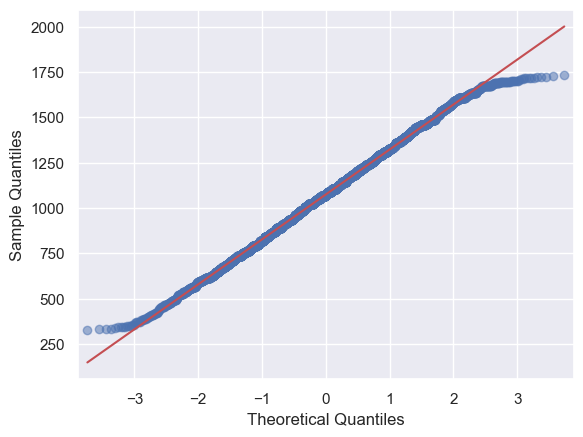

In [28]:
sm.qqplot(y_train, line='s', alpha=0.5)
plt.show()

In [29]:
y_test.describe()

count    3597.000000
mean     1074.607852
std       245.541807
min       336.953717
25%       910.794517
50%      1069.614871
75%      1238.910641
max      1731.975115
Name: transformed_salary, dtype: float64

# Starting the Model

In [30]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [31]:
# Create a model and displaying the summary
OLS_model = sm.OLS(y_train, X_train).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     76.13
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:40:21   Log-Likelihood:                -71617.
No. Observations:               10767   AIC:                         1.434e+05
Df Residuals:                   10661   BIC:                         1.442e+05
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1.755e+04   5950.849     -2.950      0.003   -2.92e+04   -5889.204
work_year                   9.1716      2.941      3.119      0.002       3.407      14.936
work_abroad               -57.5139     59.904     -0.960      0.337    -174.938      59.910
job_name_AI               100.9612     17.472      5.779      0.000      66.713     135.209
job_name_Analyst            1.7447     15.658      0.111      0.911     -28.948      32.437
job_name_Analytics         21.4031     10.424      2.053      0.040       0.969      41.837
job_name_Applied          118.4396     12.411      9.543      0.000      94.112     142.767
job_name_Architect        157.3230     18.895      8.326      0.000     120.286     194.360
job_name_Associate        -13.8087     88.919     -0.155      0.877    -188.106     160.489
job_name_Big                4.3288     69.363      0.062      0.950    -131.635     140.293
job_name_Database        -271.0084    127.744     -2.121      0.034    -521.411     -20.606
job_name_Decision          39.7724     33.492      1.188      0.235     -25.879     105.423
job_name_Deep             227.6985     63.052      3.611      0.000     104.105     351.292
job_name_Developer          8.7566     21.998      0.398      0.691     -34.364      51.877
job_name_Director         174.2549     35.775      4.871      0.000     104.129     244.381
job_name_ETL               19.5657     39.361      0.497      0.619     -57.589      96.720
job_name_Head             254.5030     31.514      8.076      0.000     192.730     316.276
job_name_Infrastructure    35.8143     33.544      1.068      0.286     -29.937     101.566
job_name_Insight          -45.4879     67.306     -0.676      0.499    -177.419      86.444
job_name_Integration       17.0738     35.157      0.486      0.627     -51.841      85.989
job_name_Lead             113.9363     25.972      4.387      0.000      63.027     164.845
job_name_NLP               93.9556     58.706      1.600      0.110     -21.119     209.030
job_name_Ops              -10.0047     53.810     -0.186      0.853    -115.482      95.473
job_name_Practitioner    -147.8965     54.476     -2.715      0.007    -254.680     -41.113
job_name_Principal        148.6851     51.246      2.901      0.004      48.234     249.137
job_name_Product          128.2341     41.084      3.121      0.002      47.702     208.767
job_name_Prompt            31.3184     72.015      0.435      0.664    -109.844     172.481
job_name_Quality         -119.0905     39.483     -3.016      0.003    -196.484     -41.697
job_name_Robotics          42.2391     62.568      0.675      0.500     -80.406     164.884
job_name_Software          53.5438     47.495      1.127      0.260     -39.555     146.643
job_name_Specialist       -54.4549     24.437  

In [32]:
pvalues = OLS_model.pvalues
print('Significant coefficients:', pvalues[pvalues <= 0.05].count())
print('Coefficients NOT significant:', pvalues[pvalues > 0.05].count(), '\n')
print(OLS_model.pvalues.sort_values().to_string())

Significant coefficients: 53
Coefficients NOT significant: 62 

experience_level_EN        5.417058e-129
experience_level_MI        1.333468e-120
job_name_Machine           3.905342e-109
job_name_Research           5.337221e-36
salary_currency_GBP         2.232832e-30
job_name_Scientist          2.332249e-25
job_name_Applied            1.687883e-21
job_name_Engineer           2.386804e-17
job_name_Architect          9.364561e-17
job_name_Head               7.423033e-16
experience_level_EX         2.142917e-12
company_location_CO         3.558722e-10
employee_residence_CO       3.558722e-10
salary_currency_EUR         7.248292e-09
job_name_AI                 7.746493e-09
company_size_S              3.084698e-07
salary_currency_CAD         5.990142e-07
job_name_Director           1.127232e-06
job_name_Lead               1.160465e-05
job_name_Vision             2.084860e-05
salary_currency_AUD         2.264888e-05
company_location_LV         2.797168e-05
employee_residence_LV       2.7971

In [33]:
y_pred = OLS_model.predict(X_test)

In [34]:
comparison_OLS = y_pred.to_frame().join(y_test.to_frame()).join((y_pred - y_test).to_frame(), lsuffix='pred')
comparison_OLS.columns = ["predicted", "test_actuals", "difference"]
comparison_OLS.describe()

,predicted,test_actuals,difference
count,3597.000000,3597.000000,3597.000000
mean,1073.305238,1074.607852,-1.302614
std,163.872818,245.541807,187.280974
min,318.938439,336.953717,-772.812919
25%,1001.861270,910.794517,-119.831848
50%,1129.092096,1069.614871,5.307528
75%,1160.509690,1238.910641,129.292944
max,1464.345896,1731.975115,690.980698


In [35]:
# Design a function to create a scatter plot
def create_scatter(model_corr, y_pred, y_test=y_test, height=7):
    m, b = np.polyfit(y_test, y_pred, deg=1)
    R_2 = pearsonr(y_test, y_pred)
    llim = min(y_test.min(), y_pred.min())
    ulim = max(y_test.max(), y_pred.max())
    
    llim = floor(llim/100)*100
    ulim = ceil(ulim/100)*100

    print('Scatter plot of Predicted vs Actual values')

    g = sns.jointplot(x=y_test, y=y_pred, kind="reg", height=height, xlim=(llim, ulim), ylim=(llim, ulim), 
                      joint_kws={'scatter_kws':dict(alpha=0.2)}, line_kws=dict(color="r"))

    for i in range(ceil(llim/400)*400+200, ceil(ulim), 400):
        g.refline(x=i, y=i, linestyle=":", alpha=.5)

    plt.xlabel('Actual y test values')
    plt.ylabel('Predicted y values')

    plt.show()

    print(f'Model R squared: {model_corr:.4f}')
    print(f'Prediction R squared: {R_2[0]**2:.4f} p-value: {R_2[1]:.4f}')
    print(f'y = {m:.4f}x {b:+.1f}')

Scatter plot of Predicted vs Actual values


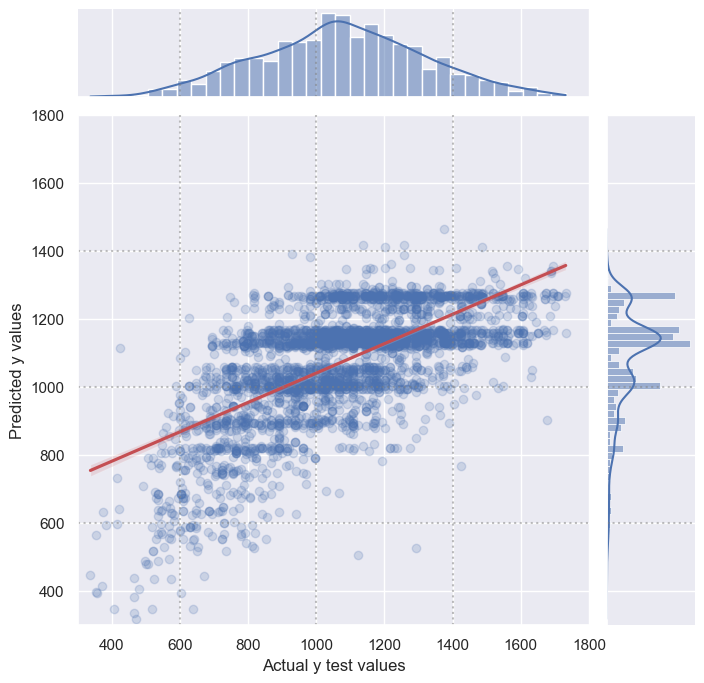

Model R squared: 0.4285
Prediction R squared: 0.4187 p-value: 0.0000
y = 0.4318x +609.3


In [36]:
create_scatter(y_pred=y_pred, model_corr=OLS_model.rsquared)

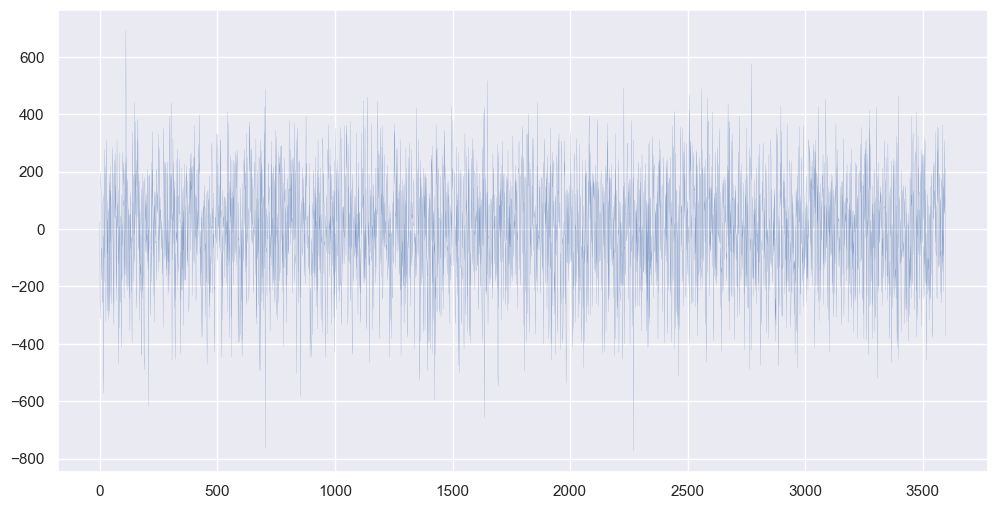

Residuals mean: -1.302614; Standard Deviation: 187.25
 Durbin Watson: 1.96


In [37]:
# Plotting the residuals
residuals_OLS = comparison_OLS.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_OLS, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_OLS.mean():.6f}; Standard Deviation: {residuals_OLS.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_OLS):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=35.398427270193174, pvalue=2.057449499872125e-08)
KstestResult(statistic=0.505775721689439, pvalue=0.0, statistic_location=3.302291955239525, statistic_sign=-1)


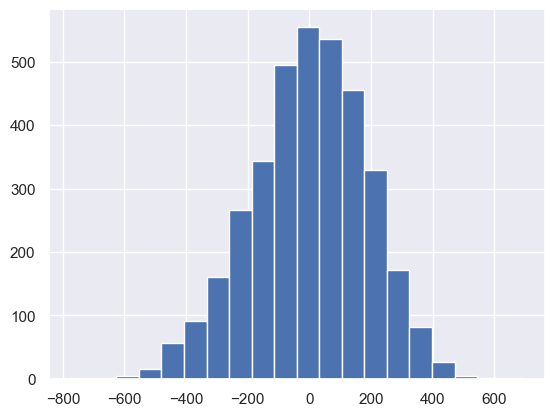

In [38]:
# tests and histogram to look at residuals' normality
print(normaltest(residuals_OLS))
print(kstest(residuals_OLS, "norm"))
plt.hist(residuals_OLS, bins=20)
plt.show()

## SIGNIFICANT ONLY

In [39]:
print('Intercept significance:', OLS_model.pvalues[OLS_model.pvalues.index == 'const'][0])

Intercept significance: 0.003186424328441639


In [40]:
X_train_step = X_train.copy()
X_test_step = X_test.copy()
y_train_step = y_train.copy()
y_test_step = y_test.copy()

X_train_step = sm.add_constant(X_train_step)
X_test_step = sm.add_constant(X_test_step)

In [41]:
# Create a model and displaying the summary

# A few variables look like they still have high p-values even in an isolated model.
# Loop until only significant variables are present
NOT_significant_vars = [1] # creation of a non empty list to enter the loop
while NOT_significant_vars != []:
    # The model is created, but a new one using only the previously resulting significant variables 
    # did not render a new model with all variables resulting significant.
    # A stepwise deletion for these variables will be done here until that happens.
    del_vars(X_train=X_train_step, X_test=X_test_step, y_train=y_train_step, y_test=y_test_step)
    OLS_model_step = sm.OLS(y_train_step, X_train_step).fit()
    y_pred_step = OLS_model_step.predict(X_test_step)

    # Bring all not significant variables into a single list
    NOT_significant_vars = OLS_model_step.pvalues[OLS_model_step.pvalues > 0.05]
    NOT_significant_vars = list(NOT_significant_vars.index)

    # remove the intercept from this list so it isn't removed from the model
    if 'const' in NOT_significant_vars:
        NOT_significant_vars.remove('const')

    X_train_step.drop(NOT_significant_vars, axis=1, inplace=True)
    X_test_step.drop(NOT_significant_vars, axis=1, inplace=True)

OLS_model_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     190.0
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:40:24   Log-Likelihood:                -71746.
No. Observations:               10767   AIC:                         1.436e+05
Df Residuals:                   10726   BIC:                         1.439e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.127e+04   5743.750     -3.702      0.000   -3.25e+04      -1e+04
work_year                11.0061      2.839      3.877      0.000       5.441      16.571
job_name_AI              91.8404     17.365      5.289      0.000      57.803     125.878
job_name_Applied        110.4538     11.487      9.616      0.000      87.937     132.970
job_name_Architect      154.7723     12.049     12.845      0.000     131.153     178.392
job_name_Deep           236.7347     63.529      3.726      0.000     112.206     361.263
job_name_Director       178.2316     36.040      4.945      0.000     107.587     248.877
job_name_Head           225.0908     29.477      7.636      0.000     167.310     282.871
job_name_Lead           109.1020     25.080      4.350      0.000      59.941     158.263
job_name_Practitioner  -144.2858     54.944     -2.626      0.009    -251.986     -36.585
job_name_Principal      158.2436     51.351      3.082      0.002      57.587     258.901
job_name_Product        128.3317     41.111      3.122      0.002      47.746     208.918
job_name_Quality       -126.6411     39.752     -3.186      0.001    -204.563     -48.720
job_name_Specialist     -57.9372     19.066     -3.039      0.002     -95.310     -20.565
job_name_Vision         126.9494     36.824      3.447      0.001      54.767     199.132
job_name_Machine        133.5143      5.953     22.428      0.000     121.845     145.183
job_name_Operations     -80.7494     24.943     -3.237      0.001    -129.642     -31.856
job_name_Engineer       127.0856      5.313     23.919      0.000     116.671     137.500
job_name_Finance        190.6685     78.793      2.420      0.016      36.220     345.117
job_name_Research       101.3294      8.008     12.654      0.000      85.633     117.026
job_name_Scientist      154.0133      5.380     28.626      0.000     143.467     164.559
job_name_Manager         50.8074     11.284      4.503      0.000      28.690      72.925
experience_level_EN    -194.6855      7.653    -25.440      0.000    -209.686    -179.685
experience_level_EX      86.9162     12.271      7.083      0.000      62.864     110.969
experience_level_MI    -108.9176      4.547    -23.953      0.000    -117.831    -100.004
employment_type_FL     -389.7126     89.121     -4.373      0.000    -564.405    -215.020
employment_type_PT     -181.1584     53.332     -3.397      0.001    -285.699     -76.618
salary_currency_AUD    -338.7887     73.030     -4.639      0.000    -481.942    -195.636
salary_currency_CAD    -197.2105     31.073     -6.347      0.000    -258.119    -136.302
salary_currency_EUR    -310.3389     14.498    -21.406      0.000    -338.757    -281.920
salary_currency_GBP    -253.1075      9.854    -25.685      0.000    -272.424    -233.791
salary_currency_INR    

In [42]:
y_pred_step = OLS_model_step.predict(X_test_step)

In [43]:
comparison_OLS_step = y_pred_step.to_frame().join(y_test_step.to_frame()).join((y_pred_step - y_test_step).to_frame(), lsuffix='pred')
comparison_OLS_step.columns = ["predicted", "test_actuals", "difference"]
comparison_OLS_step.describe()

,predicted,test_actuals,difference
count,3597.000000,3597.000000,3597.000000
mean,1074.014823,1074.607852,-0.593029
std,160.387052,245.541807,188.340944
min,207.448424,336.953717,-793.583018
25%,999.896539,910.794517,-119.094717
50%,1126.982123,1069.614871,6.486039
75%,1157.327691,1238.910641,130.895893
max,1457.866406,1731.975115,693.366248


Scatter plot of Predicted vs Actual values


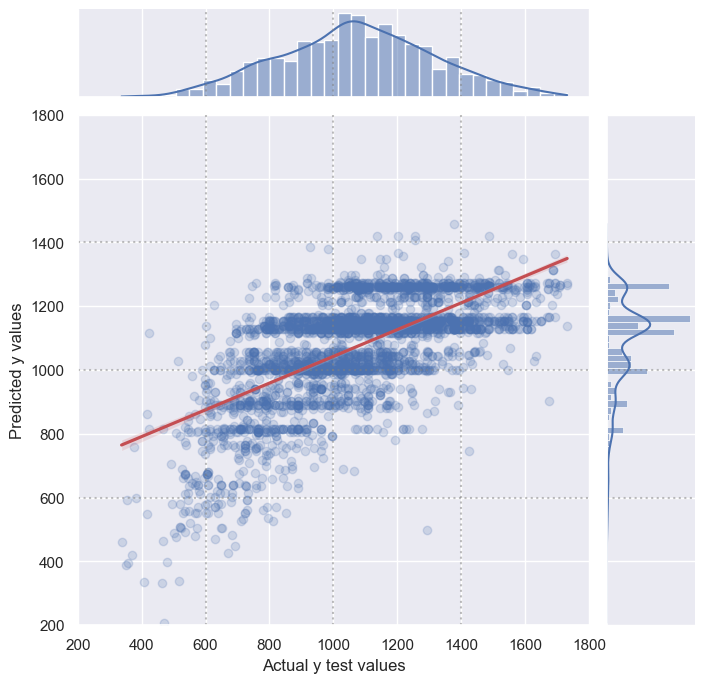

Model R squared: 0.4147
Prediction R squared: 0.4118 p-value: 0.0000
y = 0.4192x +623.6


In [44]:
create_scatter(y_test=y_test_step, y_pred=y_pred_step, model_corr=OLS_model_step.rsquared)

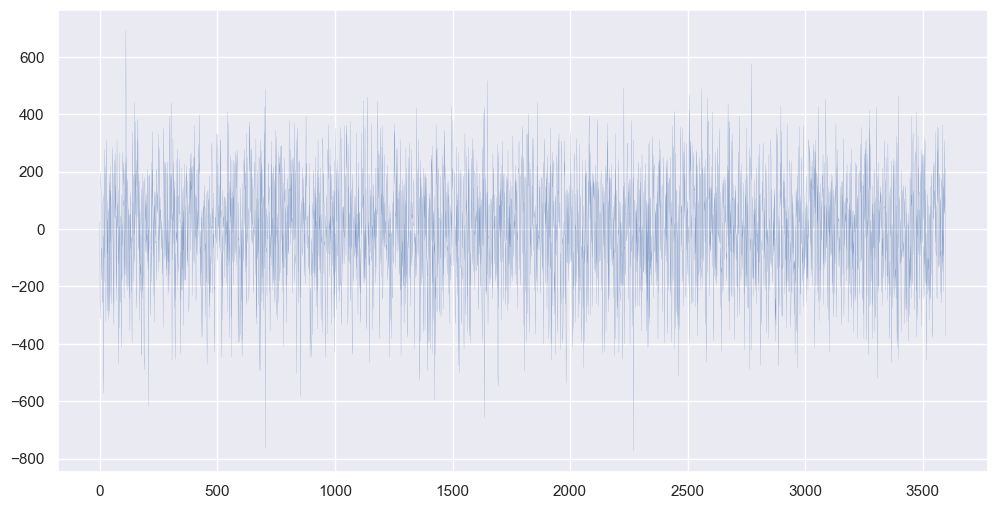

Residuals mean: -1.302614; Standard Deviation: 187.25
 Durbin Watson: 1.96


In [45]:
# Plotting the residuals
residuals_OLS_step = comparison_OLS.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_OLS_step, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_OLS_step.mean():.6f}; Standard Deviation: {residuals_OLS_step.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_OLS_step):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=35.398427270193174, pvalue=2.057449499872125e-08)
KstestResult(statistic=0.505775721689439, pvalue=0.0, statistic_location=3.302291955239525, statistic_sign=-1)


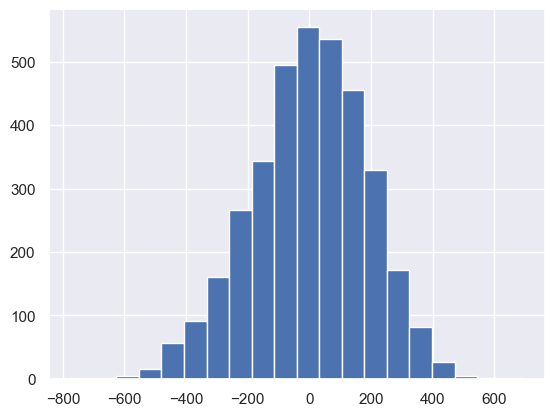

In [46]:
print(normaltest(residuals_OLS_step))
print(kstest(residuals_OLS_step, "norm"))
plt.hist(residuals_OLS_step, bins=20)
plt.show()

# Neural Network

In [47]:
# Create a model and displaying the summary
NN_model = MLPRegressor((100,100,100), max_iter=2000).fit(X_train, y_train)
# after a few iterations with nodes and depths, this was consistently the best performing model

y_pred_nn = NN_model.predict(X_test)

In [48]:
comparison_nn = pd.DataFrame(y_pred_nn).join(y_test.to_frame()).join((y_pred_nn - y_test).to_frame(), lsuffix='pred')
comparison_nn.columns = ["predicted", "test_actuals", "difference"]
comparison_nn.describe()

,predicted,test_actuals,difference
count,3597.000000,887.000000,887.000000
mean,1055.821368,1061.537899,-19.135420
std,160.629279,250.273864,187.733403
min,409.375804,407.198297,-805.909050
25%,981.469301,879.216794,-136.576153
50%,1110.416307,1058.545988,-12.171938
75%,1147.059025,1220.824530,108.944148
max,1445.164323,1731.975115,466.593395


Scatter plot of Predicted vs Actual values


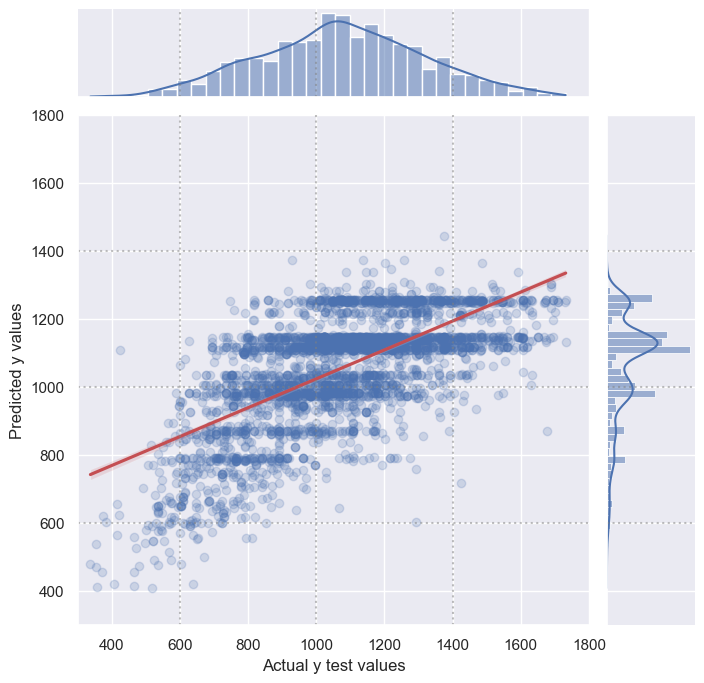

Model R squared: 0.4151
Prediction R squared: 0.4210 p-value: 0.0000
y = 0.4245x +599.7


In [49]:
create_scatter(y_pred=y_pred_nn, model_corr=NN_model.score(X_test, y_test))

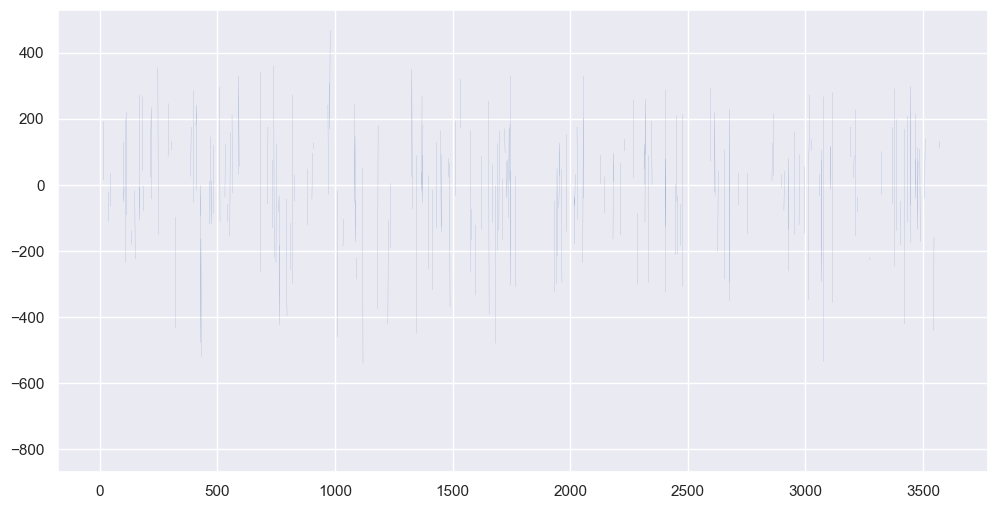

Residuals mean: nan; Standard Deviation: nan
 Durbin Watson: nan


In [50]:
# Plotting the residuals
residuals_nn = comparison_nn.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_nn, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_nn.mean():.6f}; Standard Deviation: {residuals_nn.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_nn):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=nan, pvalue=nan)
KstestResult(statistic=nan, pvalue=nan, statistic_location=nan, statistic_sign=-1)


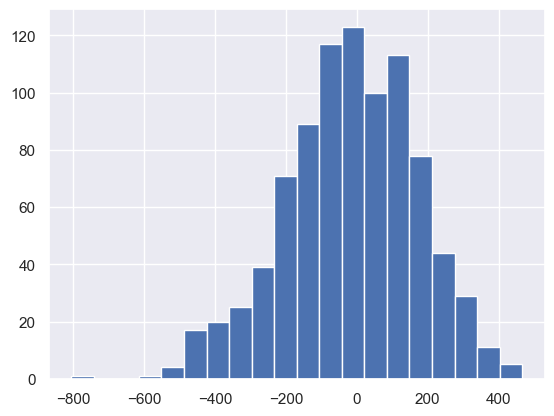

In [51]:
print(normaltest(residuals_nn))
print(kstest(residuals_nn, "norm"))
plt.hist(residuals_nn, bins=20)
plt.show()

# PCA

In [52]:
X_train = X_train.drop('const', axis=1)
X_test = X_test.drop('const', axis=1)

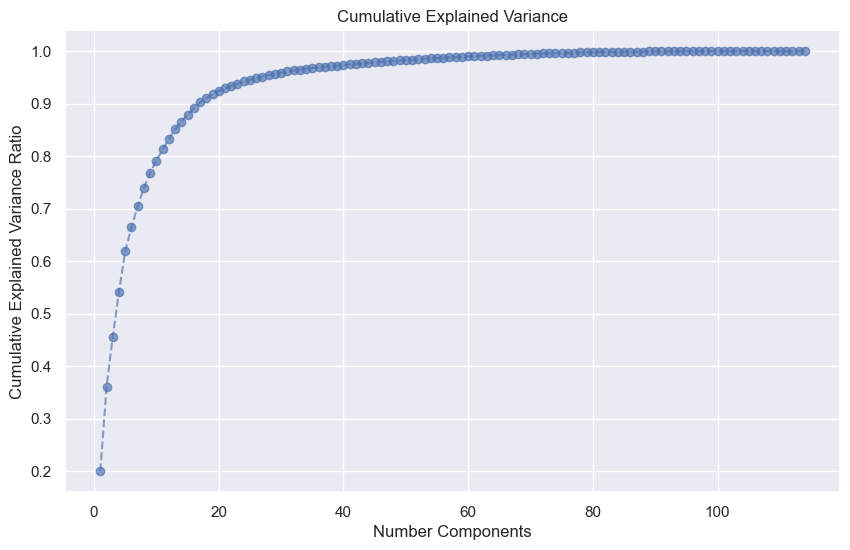

In [53]:
pca = PCA(n_components=X_train.shape[1]).fit(X_train) # fitted on train base only
X_pca_train = pca.transform(X_train) # Transforming train base
X_pca_test = pca.transform(X_test)   # Transforming test base

# Variance explained by each principal component
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, X_pca_train.shape[1] + 1), cumulative_variance_ratio, marker='o', linestyle='--', alpha=0.67)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [54]:
# Print the explained variance ratio for each component

pca_variance = pd.DataFrame({
    'Variance': pca.explained_variance_ratio_,
    'Cumulative Variance': pca.explained_variance_ratio_.cumsum(),
    'Eigenvalue': pca.singular_values_
    })
pca_variance['Component'] = pca_variance.index +1

pca_variance['Component'] = 'PC' + pca_variance['Component'].astype(str)
print(pca_variance[pca_variance.Eigenvalue >= 1].to_string())
print(pca_variance[pca_variance.Eigenvalue < 1].to_string())

    Variance  Cumulative Variance  Eigenvalue Component
0   0.199972             0.199972   72.161498       PC1
1   0.159985             0.359957   64.544749       PC2
2   0.096146             0.456103   50.036359       PC3
3   0.085930             0.542032   47.303510       PC4
4   0.077119             0.619151   44.812761       PC5
5   0.045564             0.664715   34.445425       PC6
6   0.040224             0.704939   32.363920       PC7
7   0.035052             0.739991   30.211945       PC8
8   0.028273             0.768264   27.133567       PC9
9   0.023133             0.791397   24.543626      PC10
10  0.021314             0.812711   23.558786      PC11
11  0.020098             0.832809   22.876927      PC12
12  0.018117             0.850927   21.720479      PC13
13  0.014932             0.865859   19.718859      PC14
14  0.013469             0.879328   18.727921      PC15
15  0.012129             0.891457   17.772245      PC16
16  0.010793             0.902251   16.764918   

In [55]:
components_df = pd.DataFrame(pca.components_, columns=X_train.columns).set_index(pca_variance['Component'])
components_df

,work_year,work_abroad,job_name_AI,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,job_name_Database,...,company_location_MX,company_location_NG,company_location_NL,company_location_PL,company_location_PT,company_location_SI,company_location_UA,company_location_ZA,company_size_L,company_size_S
Component,,,,,,,,,,,,,,,,,,,,,
PC1,-0.969569,9.677996e-03,-5.994558e-03,-1.053767e-02,1.374320e-03,2.444845e-04,-1.218651e-03,-8.580199e-04,1.631299e-03,-8.151212e-04,...,4.672318e-04,1.605445e-03,2.255342e-03,-2.155530e-04,2.886253e-03,0.000975,-4.070593e-04,-0.001042,7.237012e-02,2.023171e-02
PC2,0.027798,-1.669300e-03,7.933776e-03,-1.181637e-01,4.809514e-02,-5.807289e-02,-9.545458e-03,-1.450216e-04,8.729509e-04,1.329616e-03,...,2.703407e-04,-5.269267e-04,-4.172601e-04,-2.101394e-04,1.411066e-03,0.000263,3.796785e-04,0.000428,-3.847199e-02,-1.252324e-03
PC3,0.038180,2.286575e-03,-3.177058e-03,6.884999e-01,-3.536786e-03,-5.595280e-02,2.540967e-02,2.590189e-04,5.612032e-04,5.698658e-06,...,2.367716e-04,1.344315e-03,-7.218592e-04,7.872314e-04,-4.571333e-05,0.000560,-6.945093e-04,0.000584,-6.380153e-02,3.253215e-03
PC4,-0.204328,-3.179584e-03,-1.538090e-03,2.025067e-01,-1.505454e-02,-1.391745e-02,-2.237862e-02,4.963834e-04,1.258915e-03,-6.731713e-04,...,-1.158290e-03,3.948942e-04,8.177663e-04,-1.704012e-03,1.131767e-03,0.000957,-3.313351e-04,0.001038,5.842138e-02,8.241303e-05
PC5,0.033323,5.273072e-03,6.072293e-04,-1.469635e-01,2.880795e-02,3.619143e-03,-1.893343e-02,-4.754059e-05,1.120903e-03,2.411797e-03,...,9.134171e-04,3.399701e-04,1.705630e-03,6.288623e-04,6.050731e-04,0.001622,-6.935893e-04,-0.000159,1.051041e-02,7.059708e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC110,-0.000000,-7.238985e-18,3.117094e-18,9.809023e-19,-1.020584e-17,4.772410e-18,-2.347737e-18,2.224914e-17,-1.008236e-16,-3.051175e-16,...,-1.422584e-16,2.774962e-16,3.939249e-17,5.241343e-17,-1.625379e-18,-0.236081,1.554415e-16,-0.248666,-4.125591e-18,-1.122541e-17
PC111,-0.000000,-5.750713e-17,7.915510e-18,4.649678e-17,1.441000e-17,7.585739e-18,3.424043e-17,8.182685e-17,6.285962e-17,6.606071e-17,...,5.701836e-16,-2.324273e-16,9.428690e-17,1.237650e-16,-2.469149e-16,-0.097762,6.236548e-17,-0.036915,-5.102138e-18,-9.348113e-18
PC112,-0.000000,-4.785436e-17,1.124697e-17,-4.447720e-17,7.559029e-18,-9.647087e-18,-4.694536e-17,1.536511e-16,-3.731277e-17,-9.830930e-17,...,2.223248e-16,-1.739864e-17,-6.304834e-17,-2.083131e-16,-1.114063e-17,-0.128215,-2.336748e-17,-0.513446,1.032831e-18,1.333839e-17


In [56]:
# How many components have Eigenvalues larger than 1?
Eigen1 = pca_variance[pca_variance.Eigenvalue >= 1].shape[0]
Eigen1

96

In [57]:
pca_variance['Labels'] = pca_variance['Component'] + ":\n" + (pca_variance['Cumulative Variance']*100).round(1).astype(str) + '%'
pca_variance

,Variance,Cumulative Variance,Eigenvalue,Component,Labels
0,1.999719e-01,0.199972,7.216150e+01,PC1,PC1:\n20.0%
1,1.599851e-01,0.359957,6.454475e+01,PC2,PC2:\n36.0%
2,9.614555e-02,0.456103,5.003636e+01,PC3,PC3:\n45.6%
3,8.592994e-02,0.542032,4.730351e+01,PC4,PC4:\n54.2%
4,7.711897e-02,0.619151,4.481276e+01,PC5,PC5:\n61.9%
...,...,...,...,...,...
109,1.919191e-33,1.000000,7.069361e-15,PC110,PC110:\n100.0%
110,1.919191e-33,1.000000,7.069361e-15,PC111,PC111:\n100.0%
111,1.919191e-33,1.000000,7.069361e-15,PC112,PC112:\n100.0%
112,1.919191e-33,1.000000,7.069361e-15,PC113,PC113:\n100.0%


## Creating a PCA visualization plot
The main reason here is to understand each component's relation to the original variables

In [58]:
# Set cumulative variance milestones for the chart
reference_y_values = [.90, .95, .975, .99, .995, .999]
y_ticks = []
for val in reference_y_values:
    aux = pca_variance[pca_variance['Cumulative Variance'] > val]
    aux = aux.iloc[0, :]
    y_ticks.append(aux.name)
y_ticks

[16, 26, 41, 60, 70, 85]

In [59]:
# Count independent variables in categories to ease visualization
aux = []
for col in X_train.columns:
    aux.append(col[:9])
unique_entries = {}
for entry in set(aux):
    unique_entries[entry] = 0
for entry in aux:
    unique_entries[entry] = unique_entries[entry] + 1
unique_entries

{'company_l': 27,
 'employmen': 3,
 'work_abro': 1,
 'work_year': 1,
 'remote_ra': 2,
 'salary_cu': 6,
 'employee_': 27,
 'experienc': 3,
 'company_s': 2,
 'job_name_': 42}

In [60]:
# Set the limit for each new variables' category
limit_x_values = [1, 2, unique_entries['job_name_'] + 2]
for aux in ['experienc', 'employmen', 'salary_cu', 'employee_', 'remote_ra', 'company_l', 'company_s']:
    limit_x_values.append(max(limit_x_values) + unique_entries[aux])
del limit_x_values[-1:] #removing the last value as it's out of bounds for the DataFrame
print(limit_x_values)
[X_train.columns[i] for i in limit_x_values]

[1, 2, 44, 47, 50, 56, 83, 85, 112]


['work_abroad',
 'job_name_AI',
 'experience_level_EN',
 'employment_type_CT',
 'salary_currency_AUD',
 'employee_residence_AR',
 'remote_ratio_Hybrid',
 'company_location_AR',
 'company_size_L']

In [61]:
# based on the variable limits, position the ticks for a few variables for readability
xticks = [1, # work abroad
 round((limit_x_values[1] + limit_x_values[2])/2), # Job title in the middle
 limit_x_values[2],            # Experience level on one corner (will overlap with employment type, so that'll be skipped)
 limit_x_values[5]-1,                              # Currency on the other corner
 round((limit_x_values[5] + limit_x_values[7])/2), # Employee residence (middle)
 limit_x_values[7]-1,                              # Remote Ratio (middle)
 round(sum(limit_x_values[7:9])/2),                # Company Location (middle)
 limit_x_values[8]]                                # Company Size (middle)
[X_train.columns[i] for i in xticks]               # Review which variables will show

['work_abroad',
 'job_name_Principal',
 'experience_level_EN',
 'salary_currency_INR',
 'employee_residence_IE',
 'remote_ratio_Remote',
 'company_location_GR',
 'company_size_L']

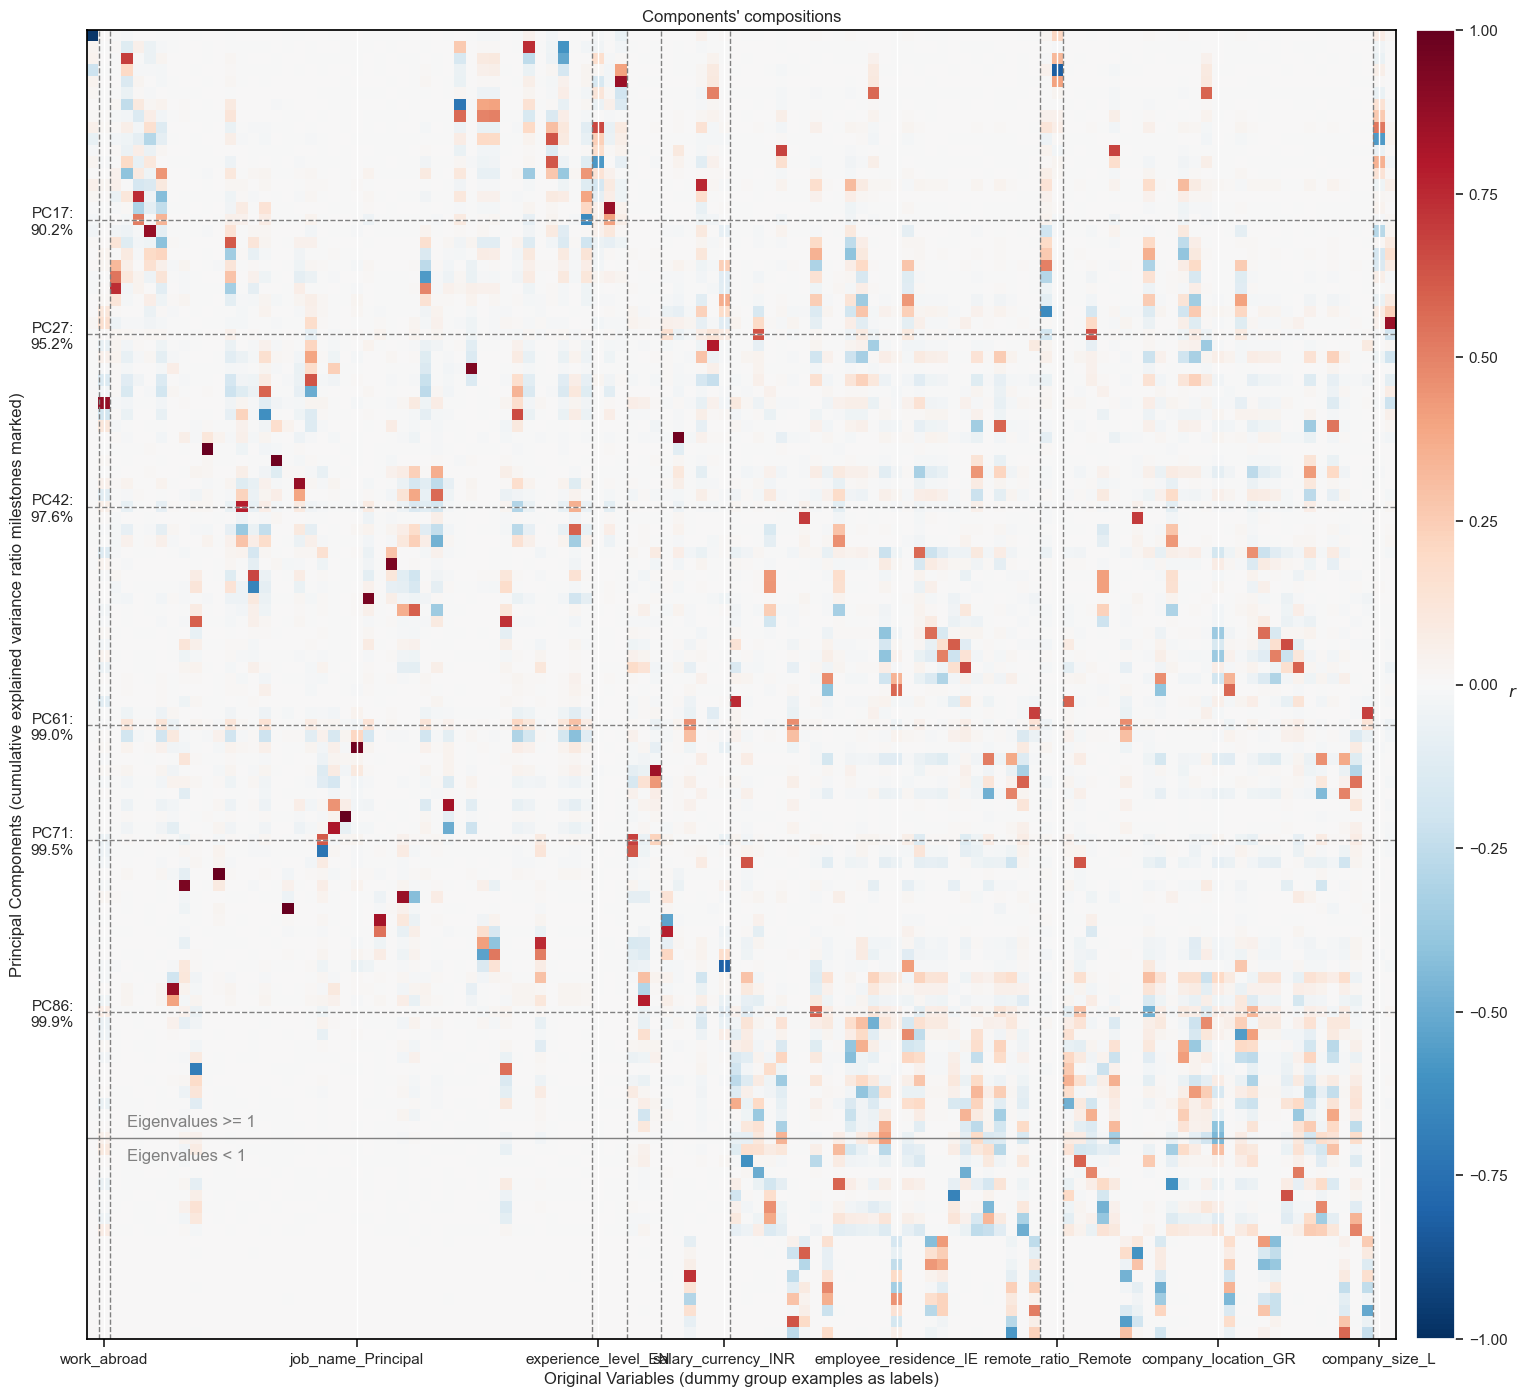

In [62]:
# Components' compositions heat matrix plot

fig, ax = plt.subplots(figsize=(18, 17))
im = ax.imshow(components_df, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_title("Components' compositions")
plt.xlabel('Original Variables (dummy group examples as labels)')
plt.ylabel('Principal Components (cumulative explained variance ratio milestones marked)')

ax.tick_params(left=False, right=False, top=False, reset=True)
ax.set_xticks(xticks)
ax.set_xticklabels(components_df.columns[xticks])
for x_value in limit_x_values:
    plt.axvline(x=x_value-0.5, color='gray', linestyle='--', linewidth=1)

ax.set_yticks(y_ticks)
ax.set_yticklabels(pca_variance['Labels'][y_ticks])
for y_value in y_ticks:
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=1)
    
plt.axhline(y=Eigen1, color='gray', linestyle='-', linewidth=1)
plt.annotate('Eigenvalues >= 1', xy=(0, Eigen1), xytext=(3, Eigen1-1), color="gray", size=12)
plt.annotate('Eigenvalues < 1', xy=(0, Eigen1), xytext=(3, Eigen1+2), color="gray", size=12)

cax = make_axes_locatable(ax).append_axes("right", size="3%", pad=0.2)
plt.colorbar(im, cax=cax).ax.set_ylabel("$r$", rotation=0)

[a.set_color("black") for a in ax.spines.values()]

plt.show()

In [63]:
# The naming used here is X_pca will be the original array and X_train_pca will be the dataframe derived from it
X_train_pca = pd.DataFrame(X_pca_train, columns = pca_variance['Component'].to_list())
X_train_pca.set_index(X_train.index, inplace=True)
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114
13633,1.077213,0.588142,-0.251959,0.363223,-0.320290,-0.049766,0.221168,-0.262607,-0.109239,0.041492,...,0.000086,-6.491496e-18,8.959330e-18,-5.775168e-18,-1.887186e-18,6.784361e-19,-4.587195e-18,-5.377657e-18,-5.260146e-19,3.304988e-18
1835,-0.861925,0.643738,-0.175600,-0.045432,-0.253644,-0.005984,0.236571,-0.244541,-0.009833,-0.106959,...,0.000179,-1.287326e-18,8.959330e-18,-5.775168e-18,-1.887186e-18,6.784361e-19,-4.587195e-18,-5.377657e-18,-5.260146e-19,3.304988e-18
4375,0.040294,0.856054,-0.360059,0.500981,0.508520,-0.205154,-0.631565,0.307955,-0.019835,0.098306,...,-0.000141,3.157903e-18,2.478868e-17,9.403663e-18,6.352751e-18,-2.032069e-18,-5.346137e-18,6.938753e-19,-4.175944e-19,-2.983385e-18
9562,0.107644,0.615940,-0.213780,0.158896,-0.286967,-0.027875,0.228869,-0.253574,-0.059536,-0.032733,...,0.000132,-3.889411e-18,8.959330e-18,-5.775168e-18,-1.887186e-18,6.784361e-19,-4.587195e-18,-5.377657e-18,-5.260146e-19,3.304988e-18
1805,-0.930241,-0.247666,0.931940,0.239421,-0.623905,0.017722,-0.209108,-0.112967,0.524554,0.049972,...,-0.001168,7.332082e-18,-1.745825e-16,-1.149543e-16,-1.449104e-17,1.222175e-16,-9.793700e-17,-8.105497e-17,6.199179e-17,2.620876e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.070272,-0.744690,-0.476619,0.083109,-0.275165,-0.018003,0.034049,-0.056804,-0.263199,-0.048552,...,-0.000604,1.367466e-17,2.554762e-17,4.199492e-18,-4.563474e-17,2.304739e-18,1.427792e-17,-2.185753e-17,-1.447586e-18,-2.549704e-18
13418,1.232963,-0.282439,1.014406,-0.189884,-0.127493,-0.112481,-0.178737,-0.091156,-0.184606,-0.024029,...,0.000036,-1.272566e-17,-6.219501e-18,-2.464029e-17,-8.571939e-19,-2.357330e-18,8.856912e-18,-3.642933e-18,1.317129e-18,5.364972e-18
5390,0.069877,-0.719988,-0.480087,0.058790,-0.301632,0.011544,0.012941,-0.037448,-0.154518,0.024339,...,-0.000032,7.819973e-18,-4.593198e-18,2.031088e-18,-7.687668e-18,5.665766e-18,-3.394573e-18,1.994918e-18,7.605502e-18,1.353424e-18
860,-0.694293,-0.702978,-0.115067,-0.969844,0.132916,0.063430,0.012872,0.014701,-0.041669,-0.038052,...,-0.000031,1.058469e-17,-2.533213e-18,7.452099e-18,-1.941396e-18,2.304739e-18,-4.045094e-18,3.079120e-18,5.274467e-18,-1.644593e-19


In [64]:
X_train_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114
count,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,...,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04,1.076700e+04
mean,-3.341026e-14,1.162460e-15,1.300385e-15,-7.023102e-15,1.237857e-15,7.634523e-16,2.521744e-16,2.486273e-16,1.713458e-15,-2.539727e-15,...,2.131872e-18,1.447184e-19,-3.918757e-20,-2.260593e-19,7.936106e-20,-2.014943e-19,-7.929360e-20,1.250163e-19,-9.309785e-20,6.890255e-20
std,6.954699e-01,6.220621e-01,4.822348e-01,4.558964e-01,4.318914e-01,3.319742e-01,3.119133e-01,2.911733e-01,2.615048e-01,2.365438e-01,...,3.885899e-03,3.017599e-17,3.274276e-17,2.905460e-17,4.254716e-17,2.528067e-17,3.099095e-17,3.015429e-17,2.109622e-17,2.598192e-17
min,-1.024987e+00,-9.069608e-01,-8.815319e-01,-1.031379e+00,-7.281731e-01,-5.346202e-01,-8.873233e-01,-4.054282e-01,-5.448321e-01,-9.068270e-01,...,-1.604403e-01,-4.132283e-16,-5.966760e-16,-3.081456e-16,-1.158789e-15,-4.009157e-16,-5.085483e-16,-3.667395e-16,-4.201123e-16,-5.518532e-16
25%,-7.061745e-01,-7.162069e-01,-3.725438e-01,-3.618954e-01,-3.092402e-01,-1.277863e-01,-1.632641e-01,-2.082812e-01,-1.483466e-01,-9.825463e-02,...,-7.835315e-05,-7.792539e-18,-6.219501e-18,-7.835152e-18,-6.603465e-18,-2.899431e-18,-5.237717e-18,-4.727136e-18,-2.857049e-18,-3.308646e-18
50%,6.987685e-02,-1.692032e-01,-1.660909e-01,8.310911e-02,-2.244351e-01,-2.502859e-02,1.294150e-02,-7.120706e-02,-5.953605e-02,-2.089966e-02,...,1.449038e-05,-7.452245e-19,2.562537e-18,-3.541567e-19,-1.887186e-18,-1.889257e-19,-3.394573e-18,-2.450311e-18,-3.812365e-20,1.353424e-18
75%,2.633942e-01,6.159400e-01,1.369466e-01,2.824022e-01,1.599626e-01,1.154399e-02,2.012974e-01,3.664215e-02,2.986805e-02,4.153911e-02,...,1.294238e-04,7.819973e-18,1.383824e-17,9.512083e-18,7.599583e-18,2.304739e-18,8.308423e-18,2.211758e-18,5.274467e-18,5.148131e-18
max,3.307856e+00,9.149618e-01,1.445840e+00,1.602237e+00,1.335469e+00,1.812106e+00,1.177835e+00,1.320830e+00,1.695754e+00,1.015191e+00,...,1.624828e-01,3.917360e-16,2.561822e-16,3.842100e-16,5.585369e-16,4.743664e-16,6.059207e-16,5.127653e-16,2.620125e-16,3.884840e-16


In [65]:
#Applying the same transformation to the test base
X_test_pca = pd.DataFrame(X_pca_test, columns = pca_variance['Component'].to_list())
X_test_pca.set_index(X_test.index, inplace=True)

# PCA Model

### Only those with eigenvalues > 1 are selected

In [66]:
components = X_train_pca.columns[:Eigen1]
X_train_eigen1 = X_train_pca[components]
X_train_eigen1 = sm.add_constant(X_train_eigen1)
X_test_eigen1 = X_test_pca[components]
X_test_eigen1 = sm.add_constant(X_test_eigen1)

In [67]:
# Create a model with PCA cols
OLS_model_PCA = sm.OLS(y_train, X_train_eigen1).fit()
OLS_model_PCA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     83.06
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:40:48   Log-Likelihood:                -71625.
No. Observations:               10767   AIC:                         1.434e+05
Df Residuals:                   10670   BIC:                         1.441e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1075.3165      1.814    592.693      0.000    1071.760    1078.873
PC1          -21.1691      2.609     -8.114      0.000     -26.283     -16.055
PC2           39.1631      2.917     13.427      0.000      33.446      44.880
PC3         -185.6035      3.762    -49.331      0.000    -192.979    -178.228
PC4         -124.6994      3.980    -31.333      0.000    -132.501    -116.898
PC5         -100.1323      4.201    -23.835      0.000    -108.367     -91.898
PC6          -97.5548      5.465    -17.850      0.000    -108.268     -86.842
PC7          -43.7340      5.817     -7.518      0.000     -55.136     -32.332
PC8           19.7538      6.231      3.170      0.002       7.539      31.968
PC9         -167.9873      6.938    -24.212      0.000    -181.587    -154.387
PC10          -2.0097      7.670     -0.262      0.793     -17.045      13.026
PC11         -87.8698      7.991    -10.996      0.000    -103.534     -72.206
PC12         203.1537      8.229     24.687      0.000     187.023     219.284
PC13          -4.0528      8.667     -0.468      0.640     -21.042      12.937
PC14        -258.8656      9.547    -27.115      0.000    -277.580    -240.151
PC15         -41.3525     10.052     -4.114      0.000     -61.057     -21.648
PC16          83.9781     10.593      7.928      0.000      63.214     104.742
PC17          99.9898     11.229      8.904      0.000      77.978     122.001
PC18          80.8987     12.634      6.403      0.000      56.133     105.664
PC19         -80.9743     14.100     -5.743      0.000    -108.614     -53.335
PC20         107.3312     14.575      7.364      0.000      78.761     135.902
PC21        -103.3162     16.590     -6.228      0.000    -135.835     -70.798
PC22         220.7277     16.829     13.116      0.000     187.740     253.716
PC23          79.4556     17.781      4.469      0.000      44.602     114.309
PC24        -160.4523     18.015     -8.907      0.000    -195.764    -125.140
PC25        -145.1852     19.985     -7.265      0.000    -184.359    -106.011
PC26         -60.7128     20.899     -2.905      0.004    -101.678     -19.748
PC27         -32.5064     21.980     -1.479      0.139     -75.592      10.579
PC28        -141.5724     22.829     -6.201      0.000    -186.322     -96.822
PC29         -33.9207     23.316     -1.455      0.146     -79.625      11.784
PC30         -68.7307     24.173     -2.843      0.004    -116.113     -21.348
PC31         214.1637     24.608      8.703      0.000     165.928     262.399
PC32           2.9853     26.176      0.114      0.909     -48.324      54.294
PC33         -71.4584     28.990     -2.465      0.014    -128.284     -14.632
PC34        -115.2108     29.962     -3.845      0.000    -173.943     -56.479
PC35        -110.7196     30.914     -3.581      0.000    -171.318     -50.122
PC

In [68]:
y_pred_eigen1 = OLS_model_PCA.predict(X_test_eigen1)

In [69]:
comparison_eigen1 = y_pred_eigen1.to_frame().join(y_test.to_frame()).join((y_pred_eigen1 - y_test).to_frame(), lsuffix='pred')
comparison_eigen1.columns = ["predicted", "test_actuals", "difference"]
comparison_eigen1.describe()

,predicted,test_actuals,difference
count,3597.000000,3597.000000,3597.000000
mean,1073.425976,1074.607852,-1.181877
std,163.548252,245.541807,186.944229
min,333.118349,336.953717,-792.534842
25%,1002.321252,910.794517,-119.571749
50%,1129.298245,1069.614871,5.315814
75%,1160.266163,1238.910641,129.490407
max,1463.226974,1731.975115,691.278990


Scatter plot of Predicted vs Actual values


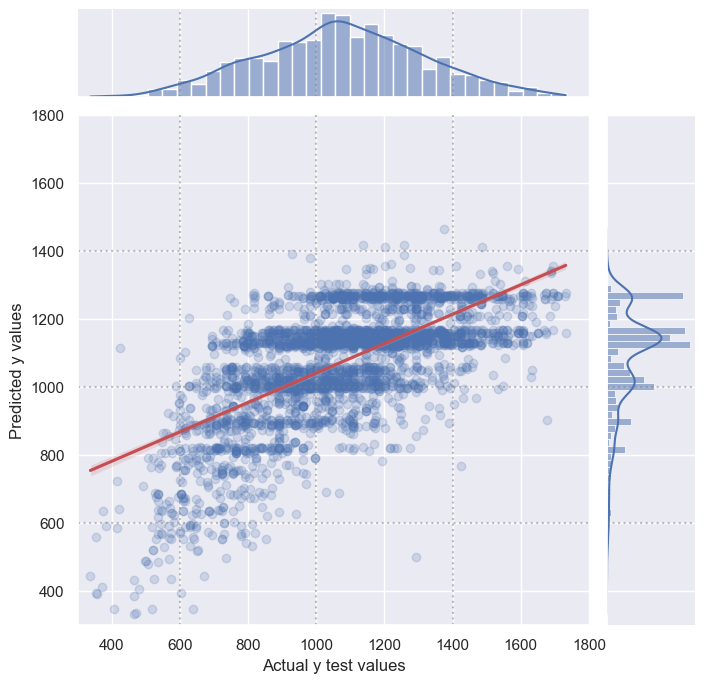

Model R squared: 0.4277
Prediction R squared: 0.4206 p-value: 0.0000
y = 0.4320x +609.2


In [70]:
create_scatter(y_pred=y_pred_eigen1, model_corr=OLS_model_PCA.rsquared)

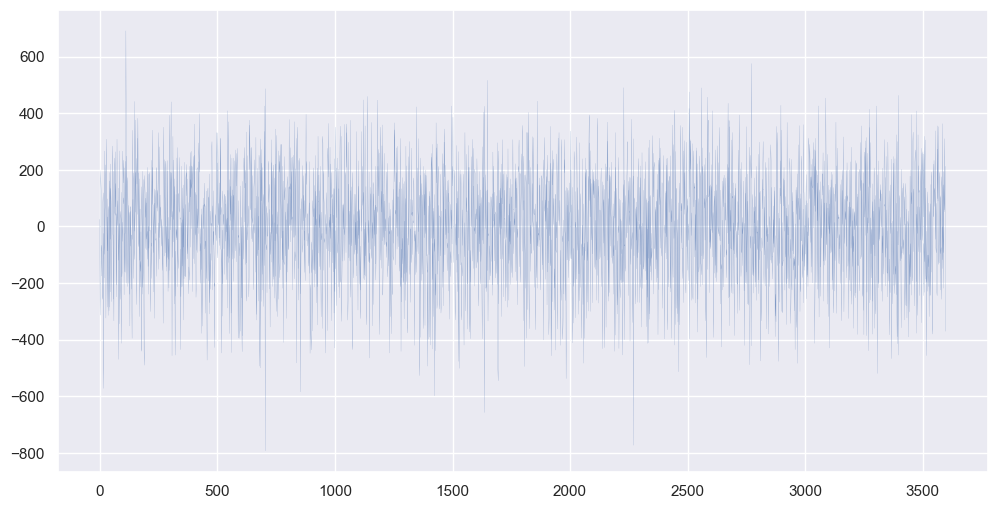

Residuals mean: -1.181877; Standard Deviation: 186.92
 Durbin Watson: 1.96


In [71]:
# Plotting the residuals
residuals_OLS_PCA = comparison_eigen1.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_OLS_PCA, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_OLS_PCA.mean():.6f}; Standard Deviation: {residuals_OLS_PCA.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_OLS_PCA):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=34.033579716174025, pvalue=4.0710090227485045e-08)
KstestResult(statistic=0.506030437392581, pvalue=0.0, statistic_location=3.2889638242938872, statistic_sign=-1)


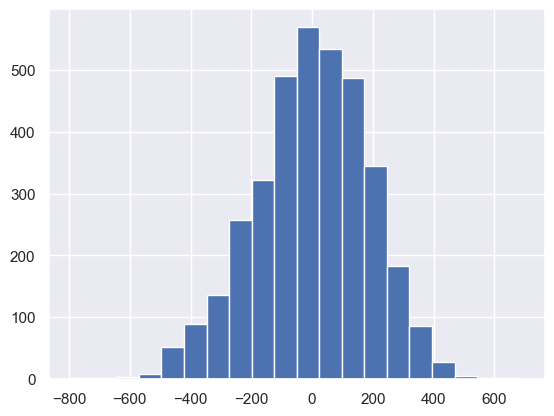

In [72]:
# tests and histogram to look at residuals' normality
print(normaltest(residuals_OLS_PCA))
print(kstest(residuals_OLS_PCA, "norm"))
plt.hist(residuals_OLS_PCA, bins=20)
plt.show()